# Tutorial: Generative Adversarial Networks - Advanced Techniques
### - *Jonas Glombitza, RWTH Aachen University, IML 2019, CERN*
This tutorial is about _generative models_ and especially **Generative Adversarial Networks** (**GANs**).
In this tutorial we will implement different types of GANs, which were proposed recently:
- Vanilla GAN - https://arxiv.org/abs/1406.2661
- Conditional GAN - https://arxiv.org/abs/1610.09585
- Wasserstein GAN (WGAN-GP) - https://arxiv.org/abs/1704.00028
- Spectral Normalization SN-GAN - https://arxiv.org/abs/1802.05957

and learn about further techniques to stabilize the training of GANs. (DCGANs, conditioning of the generator ...).
To train our generative models, we will have a look on three different data sets (1 from computer vision, 2 physics data sets):
1. [ CIFAR10 ](https://www.cs.toronto.edu/~kriz/cifar.html)
2. [ Footprints of Cosmic Ray induced Air Showers ](https://link.springer.com/article/10.1007/s41781-018-0008-x)
3. [ Electromagnetic Calorimeter Images (multi-layer) ](https://doi.org/10.1007/s41781-018-0019-7)

As framework, we make use of [TensorFlow](https://www.tensorflow.org/) and especially:
- [Keras](https://keras.io/): Keras API shipped with TensorFlow
- [TensorFlow-GAN](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/gan): lightweight library for training GANs

#### Table of contents
1. [ Basics ](#basics)

2. [ Generative Adversarial Networks ](#gan)
 1. [ Theory ](#gan_theory)
 2. [ CIFAR10: Example](#gan_code)
 3. [Implementation](#gan_code)
 
3. [ Wasserstein GANs ](#wgan)
 1. [ Theory ](#wgan_theory)
 2. [ CIFAR10: Example](#wgan_code)
 3. [ Results](#wgan_result)
 
4. [ Spectral Normalization for GANs ](#sngan)
 1. [ Theory ](#sngan_theory)
 2. [ Physics Example: Cosmic Ray induces Air Showers](#sngan_code)
 3. [ Results](#sngan_result)
 
5. [ Calorimeter Images](#calgan)
 1. [ Generator conditioning ](#calgan_theory)
 2. [ Physics Example: Calorimeter images](#calgan_code)
 3. [ Results](#calgan_result)
   
   
<a name="basics"></a>
# Basics
&nbsp; 
<details><summary> <button type="button">Display detailed text</button> </summary>
<p>

## Generative Models
Before we jump into the implementation of several GANs, we need to introduce _Generative Models_.

Let us assume we have a bunch of images which forms the distribution of real images $P_{r}$.
In our case (CIFAR10 dataset) the distribution consists of several classes: `horse, airplane, bird, frog, truck, deer, cat, dog, car, ship`.
Instead of training a classifier to be able to label our data, we now would like to generate samples which are 
similar to samples in the distribution $P_{r}$ formed by the bunch of images.
The clue is, that we would like to generate **new samples** which were **not part** of the dataset, but look really similar.
 
![CIFAR 10 images](https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Fgan%2Fimages&files=CIFAR10_collection.png)

So in a mathematical way, we would like to approximate the real distribution $P_{r}$ with a model $P_{\theta}$.
With this *generative* model, we then would like to generate new samples ($x \sim P_{\theta}$).

<a name="gan"></a>
## Generative Adversarial Networks
The basic idea of Generative Adversarial Networks (GANs) is to train a **generator network** to learn the underlying data distribution.<sup>[1](#myfootnote1)</sup>
In other words, we would like to design a generator machine, we can feed with noise and which outputs us nice samples following
the distribution of real images $P_{r}$, but which were not part of the training dataset.
So in our case, we would like to generate new samples of airplanes, cars, dogs etc..
 
 <img src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Fgan%2Fimages&files=generator_machine.png" alt="generator_machine" width="800"/>

In our setup we use a neural network $G(z)$ as generator machine. 
The generator network $G(z)$ gets as input a noise vector $z$ sampled from a multidimensional noise distribution $z \sim p(z)$.
This space of $z$ is often called latent space. The generator should then map the noise vector $z$ into the data space (the space where our
real data samples lie) and output new samples/images $\tilde{x} \sim G(z)$. We would like to have these $\tilde{x}$ very similar to the real samples $x \sim P_{r}$.

For the training of our generator network we need feedback, if the generated samples are of good or bad quality.
Because a classical supervised loss is incapable for giving a good feedback to the generator network, it is trained in an unsupervised manner.
So instead of using "mean squared error" or similar metrics, the performance measure is given by a **second** _adversarial_ neural network, which is called _discriminator_.
In the vanilla GAN setup, the way of measuring the quality of the generated samples should be given by a classifier which is trained
to classify between fake `class=0` (generated by our generator network) and real images `class=1` (from our bunch of images).

The clue is, that the generator should try to fool the discriminator.
So, by adapting the generator weights the discriminator should fail to identify the fake images, and should output `class=1` (real images)
when generated images are input into the discriminator. It is crucial, that we can directly get this feedback when stacking the generator on top
of the discriminator to build our GAN framework. Because both are neural networks, we just can propagate the gradient 
through the discriminator to the generator, which can then adapts its weights to generate samples of better quality.
In simple words, the generator should change the weights in a such a way, that the discriminator identifies
the generated samples as real images.
When iteratively adapting the weights of the discriminator and generator, the performance of generated images should increase stepwise.
This is the fascinating idea of _adversarial training_.


<img src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Fgan%2Fimages&files=adversarial_training_sketch.png" alt="drawing" width="800"/>

In a very figurative sense, the discriminator could be seen as painter which is able to classify between
real images and fake images, because he knows a little bit about colors and art. We now would like to build a generator machine
which produce nice photographs.
The idea is, to fool the painter (discriminator) by changing the parameters of our machine.
Because the painter has knowledge how "real images" look like, the feedback of him helps us to modify the generator machine in such a way that it will produce images of better quality.

<a name="gan_theory"></a>
### Adversarial training
After introducing the basic idea of adversarial training, let us now understand the math and focus on the algorithm itself.
 
Our adversarial framework consists of 2 networks:
- the generator network $G$ (learn the mapping from noise $z$ to images $\tilde{x}$)
- the discriminator $D$ network (measures the image quality, by discriminating if the images are true `class=1` or fake `class=0`)

The iterative update procedure of the framework is as follows:
    1. Discriminator update: train discriminator to classify between fake and real images
    2. Generator update: train generator to fool the discriminator
    -  Repeat from beginning


#### Discriminator update
Sample noise vectors from the latent space $z \sim p(z)$.
Generate new fake samples by feeding the sampled vectors $z$ into the generator $G(z)$ to obtain the new samples $\tilde{x} \sim G(z)$.
Subsequently, we sample from the real distribution and obtain a bunch of samples $ x \sim P_{r}$.
We now train the discriminator using the binary cross entropy by changing the weights $w$ of the discriminator:

$ \mathcal{L}_{Dis} = \min{ -\mathbb{E}_{\mathbf{x} \sim p_{data}(\mathbf{x})} [log(D_w(\mathbf{x}))] - \mathbb{E}_{\mathbf{z} \sim p_z(\mathbf{z})} [log(1-D_w(G_{\theta}(\mathbf{z})))]}$

This is just the typical supervised training of a classifier.


#### Generator update
Firs, we sample noise from the latent space $z \sim p(z)$.
Generate new fake samples by feeding the noise into the generator $G(z)$ and obtain a bunch of generated samples $\tilde{x} \sim G(z)$.
Now we freeze the weights $w$ of the discriminator.
Finally, we train the generator to fool the discriminator, by adapting the weights $\theta$ of our generator network:

$ \mathcal{L}_{Gen} = \max{ -\mathbb{E}_{\mathbf{z} \sim p_z(\mathbf{z})} [log(1-D_w(G_{\theta}(\mathbf{z})))]}$

By iteratively passing these steps of discriminator and generator updates, we train our framework.

### Architectures
Building a powerful architecture of the discriminator and generator is rucial for successful GAN training.
Remember, that the generator maps from the latent space into the data space.
Hence, the input should be a 1D-vector of noise variables and the output should have image dimensions.
In this case the output will have the dimension `(32, 32, 3)`. (3 color channels: RGB)

[Radford, Metz, and Chintala](https://arxiv.org/abs/1511.06434) proposed stable architectures for generator and discriminator networks.
These DCGAN "guidelines" can be summarized as follows:
- Replace fully connected layers with convolutional layers
- Do not use pooling layers, use striding instead
- Make use of batch normalization in generator and discriminator to stabilize training<sup>[2](#myfootnote2)</sup>
- Use [LeakyReLU](https://arxiv.org/pdf/1505.00853.pdf) activation in discriminator for better feedback<sup>[3](#myfootnote3)</sup>
- Use a pyramidal topology in the generator by using transposed convolutions, to support a simple and structured latent space

<img src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Fgan%2Fimages&files=DCGAN_generator.png" alt="drawing" width="800"/>
<div style="text-align: right"> image credit: Radford, Metz, Chintala </div>



_Footnotes_

<a name="myfootnote0">0</a>: Let us assume we are using mean squared error $(\tilde{x}-x)^2$ as loss. This will lead to 2 problems.
- we learn sample generation in a strange way: we input noise and assign somehow a label (true image) to this noise
- even if the generated sample has good quality (maybe a nearly perfect cat), the error would be large when the sample is shifted by a few pixel, rotated or somehow transformed with respect to the "label" (real image)


<a name="myfootnote1">1</a>: In contrast to e.g. [_Variational Autoencoders_](https://arxiv.org/abs/1312.6114) the idea is not to "fit the distribution in a space of compressed representation"
but to train a generator which approximates the real distribution directly.
Remember that in VAEs we learn a mapping in to the latent space where we can "fit" a gaussian. Therefore, after the training we can just
generate new samples by sampling from the latent space using the Gaussian prior.
Because most problems are to complex, the Gaussian is not able to capture all modes, this leads to blurry images which is
a well known problem for VAE generated samples. Furthermore, VAEs minimize the Kullback-Leibler divergence, which is not a well suitable distance measure.

<a name="myfootnote2">2</a>: Batch normalization is very important here. Due to the normalization of the gradients, it stabilizes the training.
As we will see [later](#sngan_normalization) normalizing the gradients delivered by the discriminator, is crucial.

<a name="myfootnote3">3</a>: Using ReLU in the discriminator would lead to sparse gradient (no negative gradient could propagate back).
Using LeakyReLU provides better feedback. Also pooling would provide sparse gradients.

</p>
</details>

&nbsp; 
<a name="gan_code"></a>
## Implementation Vanilla GAN
Let us start to implement our first GAN in Keras, to gain more insights of the training procedure.
First we need to import the libaries.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from platform import python_version
import tutorial as tut

print("Python version", python_version())
print("\nTensorFlow version", tf.__version__)
print("Keras version", keras.__version__)

eos access: ✗
Python version 3.6.7

TensorFlow version 1.13.1
Keras version 2.2.4-tf


First of all we have to load our training data.
Furthermore, we can have a look on the first 16 images of the CIFAR10 dataset.
For the later training of networks it is from big advantage to preprocess our data, because neural networks prfoit from 
normalize data we rescale the images to [-1,1].

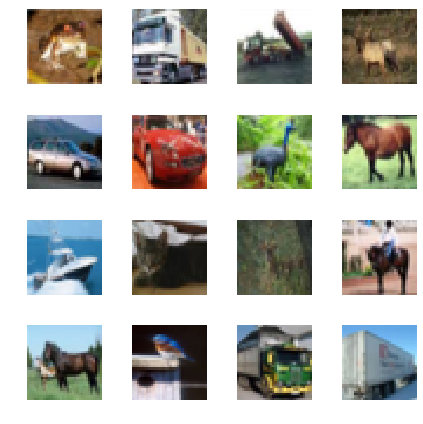

In [40]:
from matplotlib import pyplot as plt
from plotting import plot_images

(images, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
plot_images(images[:16])
x_train = 2 * (images / 255. - 0.5)

Now we can design our generator and discriminator network.
Let us begin with a straight forward implementation of the generator network, following the DCGAN guidelines.
As noise input we sample from a `latent_dim = 64` dimensional latent space.

In [3]:
layers = keras.layers

print('Generator')
latent_dim = 64
generator_input = layers.Input(shape=[latent_dim])
x = layers.Dense(2 * 2 * 512, activation='relu')(generator_input)
x = layers.Reshape([2, 2, 512])(x)
x = layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, (5, 5), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(3, (3, 3), padding='same', activation='tanh')(x)
generator = keras.models.Model(inputs=generator_input, outputs=x)
print(generator.summary())

Generator
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2048)              133120    
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         6554112   
_________________________________________________________________
batch_normalization_v1 (Batc (None, 4, 4, 512)         2048      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3277056   
____________________________________________________________

As we can see, we build a generator with ~ 10 M parameters, which maps from the latent space `(64,)` to the data space `(32,32,3)`.
Notice, that using `tanh` as last activation is important, because we scaled the images to [-1,1].


In [4]:
print('Discriminator')
discriminator_input = layers.Input(shape=[32, 32, 3])
x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, (4, 4), padding='same', strides=(2, 2))(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(256, (4, 4), padding='same', strides=(2, 2))(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(512, (4, 4), padding='same', strides=(2, 2))(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(2, activation='softmax', kernel_regularizer=keras.regularizers.l1_l2(0.0004))(x)
discriminator = keras.models.Model(inputs=discriminator_input, outputs=x)
print(discriminator.summary())


Discriminator
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         524544    
_____________

Furthermore, we created our discriminator which classifies the input images of shape `(32,32,3)` into `(2,)` classes (fake, real)
holding ~2.5 M parameters.

Now, we can compile our model by choosing an optimizer and setting the objective.

In [5]:
d_opt = keras.optimizers.Adam(lr=2e-4, beta_1=0.5, decay=0.0005)
discriminator.compile(loss='binary_crossentropy', optimizer=d_opt, metrics=['accuracy'])


After creating our discriminator model, we have to build and compile the GAN framework by stacking the discriminator on 
top of the generator.


In [6]:
print('\nGenerative Adversarial Network')
gan_input = layers.Input(shape=[latent_dim])
gan_output = discriminator(generator(gan_input))
GAN = keras.models.Model(gan_input, gan_output)
print(GAN.summary())



Generative Adversarial Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64)                0         
_________________________________________________________________
model (Model)                (None, 32, 32, 3)         11096771  
_________________________________________________________________
model_1 (Model)              (None, 2)                 2759298   
Total params: 13,856,069
Trainable params: 13,854,021
Non-trainable params: 2,048
_________________________________________________________________
None


After building the framework, we have to compile it.
But before, we have to **freeze the weights of the discriminator**. (Remember that for training the generator, we have to fix the discriminator weights, because we want to fool the discriminator by drawing nice images, not by making our discriminator 
a bad classifier).

In [7]:
def make_trainable(model, trainable):
    """ Function to freeze / unfreeze a model """
    model.trainable = trainable
    for l in model.layers:
        l.trainable = trainable

g_opt = keras.optimizers.Adam(lr=2e-4, beta_1=0.5, decay=0.0005)
make_trainable(discriminator, False)  # freezes the discriminator when training the GAN
GAN.compile(loss='binary_crossentropy', optimizer=g_opt)


Note that after we compiled a model, calling `make_trainable` will have no effect untill compiling the model again.

We now can design the training loop of our framework:

In [8]:
# loss vector
losses = {"d": [], "g": []}
discriminator_acc = []

def train_gan(epochs=0, batch_size=64):
    for epoch in range(epochs):
    
        # Plot some fake images
        noise = np.random.randn(batch_size, latent_dim)
        generated_images = 255. * (generator.predict(noise) / 2. + 0.5)
        plot_images(generated_images[:16])  # plot image
    
        perm = np.random.choice(50000, size=50000, replace='False')
    
        for i in range(50000//batch_size):
    
            # Create a mini-batch of data (X: real images + fake images, y: corresponding class vectors)
            image_batch = x_train[perm[i*batch_size:(i+1)*batch_size], :, :, :]    # real images
            noise_gen = np.random.randn(batch_size, latent_dim)
            generated_images = generator.predict(noise_gen)                        # generated images
            X = np.concatenate((image_batch, generated_images))
            y = np.zeros([2*batch_size, 2])   # class vector
            y[0:batch_size, 1] = 1
            y[batch_size:, 0] = 1
    
            # Train the discriminator on the mini-batch
            d_loss, d_acc = discriminator.train_on_batch(X, y)
            losses["d"].append(d_loss)
            discriminator_acc.append(d_acc)
    
            # Create a mini-batch of data (X: noise, y: class vectors pretending that these produce real images)
            noise_tr = np.random.randn(batch_size, latent_dim)
            y2 = np.zeros([batch_size, 2])
            y2[:, 1] = 1  # Fooling: We need to take the label 1, (real) because Keras will minimize the cross entropy in our model,
                          # Switching the label to real here, will let us maximize as required . 

            # Train the generator on the mini-batch
            g_loss = GAN.train_on_batch(noise_tr, y2)
            losses["g"].append(g_loss)
            print(discriminator_acc[-1])

We now just could train our network by calling `train_gan(epochs=100)`.

###### WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
-> This warning is harmless and just occurs, because we compiled the discriminator and later froze its weights for the generator training.

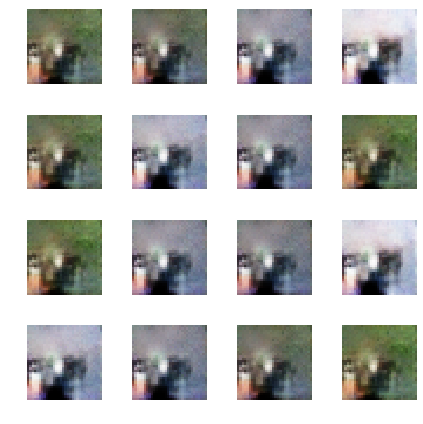

In [9]:
gan_dir = tut.get_file("gan/models/vanilla_GAN/generator.h5")
pretrained_generator = keras.models.load_model(gan_dir)
noise = np.random.randn(16, 64)
generated_images = 255. * (pretrained_generator.predict(noise) / 2. + 0.5)
plot_images(generated_images)  # plot images


## Results

As we can see, the results are very noisy and the generator seems to output really similar image samples of relatively bad quality.
In order not to judge too quickly, you should remember that generating images is a quiet complicated task. 32x32x3 = 3072 dimensional!
The dataset holds 10 classes, with complicated structures. [MNIST](http://yann.lecun.com/exdb/mnist/) is comparatively much much easier.
By randomly sampling from noise, you will never be able to generate a sample looking like any of the images, it will just be noise!

Still, we can see that our model is only able to produce rough details and local regions of smooth colors, capturing only a single mode.


Samples during training            |  Loss
:-------------------------:|:-------------------------:
<img src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Fgan%2Fmodels%2Fvanilla_GAN&files=cifar10_vanilla.gif" width="400"/>  |  <img src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Fgan%2Fmodels%2Fvanilla_GAN&files=loss.png" width="400"/>


By looking on the generated images during the training, we can see that each iteration another mode (every image look very similar) is displayed.
The generator seems to switch these modes but without improving the general image quality. Our can suffers from mode collapsing!

When we have a look on the loss we have no visible of convergence or anything which could tell us about successful training.
We can just see that discriminator an generator are on a same scale, but there is no kind of convergence or anything else.


For increasing the generation performance we need to understand what's wrong with the vanilla GAN training.

### Problems of Training GANs
&nbsp;
<details><summary> <button type="button">Display detailed text</button> </summary>
<p>


In general, training GANs is a very challenging task and needs a lot of fine tuning compared to supervised training of deep networks.
The reason for this is, that we do not have a stationary minimization problem anymore, but two networks playing a _minmax game_.
The updates of the generator will highly affect the next discriminator update and the other way round.
Because of the non-stationary minimization problem, do not use optimizers with high momentum rates!

Beside this:
- Mode collapsing
- Vanishing gradients
- Meaningless loss metric

are further issues of our vanilla GAN framework.

##### Mode Collapsing - "Helvetica Scenario"
After the training, the generator outputs samples from a restricted phase space only.
This is heavily connected to the control of the discriminator gradients. When the discriminator covers only a part of the modes in data,
the feedback will only be informative towards this modes. This heavily drives the generator to collapse towards this mode, which forces the discriminator to focus on a different mode.

<img src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Fgan%2Fimages&files=mnist_mode_collapse.png" alt="drawing" width="487"/>

To solve this, one can try to use:
- Batch history (add in the present batch of generated samples, samples generated by the model in earlier iterations)
- Add noise into the framework
- Label smoothing or switching (see [non saturating GAN](#ns_gan))
- Conditioning of GANs - change to semi supervised training by adding label information to generator and/or discriminator
    - C-GAN : condition the generator to produce specific samples, [Mirza, Osindero](https://arxiv.org/abs/1411.1784)
    - AC-GAN: let the discriminator learn a conditional probability over the classes, [Odena, Olah, Shlens](https://arxiv.org/abs/1610.09585)
    

##### Vanishing Gradients
For training a reasonable generator, the feedback of the discriminator is crucial.
Therefore, one could think that training the discriminator more often than the generator could improve the training,
because the feedback would be much more precise.
The problem is, that for this scenario the feedback of the discriminator is almost zero.
![vanishing gradients](https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Fgan%2Fimages&files=vanishing_gradients.gif)
<div style="text-align: right"> image credit: Emanuele Sansone </div>
When calculating the gradient for the generator update provided by a converged discriminator, one obtains vanishing feedback:
 
$\lim_{D \rightarrow 0} \frac{\partial{}}{\partial{\theta}} \log(1-D(G_{\theta}(z))) = \lim_{f \rightarrow -\infty} \frac{\partial{}}{\partial{\theta}}\log\left( 1- \frac{1}{1+e^{-f_{\theta}}} \right) \approx 0$

Hence, having a strong discriminator will hinder the training, this is very bad!
In order to prevent that, we used regularization (dropout + l1 + l2) in the discriminator.

#### Meaningless Loss
By inspecting the loss of the discriminator and generator, we can see that they do not correlate with the image quality.
(the discriminator is not trained to convergence). Hence, it is quiet hard to say if our framework reached a stable equilibrium.
This is really bad for monitoring the training.

To sum it up, most basic methods which shoud help stabilizing the training process, include noise or noisy updates.
This is terrible, because it will highly affect our performance and will make our generated samples noisy.

### Towards Softer Metrics
To understand the instable GAN training, one can try to interpret the training of GAN as _divergence minimization_ between the probability densities $P_r$ and $P_\theta$.
Assuming a optimal discriminator, the traditional GAN setup minimizes the Jensen-Shannon (JS) divergence.

$\mathcal{D}_{JS}(P_r|| P_\theta)=\mathcal{D}_{KL}(P_r|| P_m) + \mathcal{D}_{KL}(P_\theta|| P_m)$,&nbsp;

with $\mathcal{D}_{KL}(P_r || P_\theta )= \mathbb{E}_{\mathbf{x} \sim P_r} log\left(\frac{P_r}{P_\theta}\right)\;$ and $P_m = \frac{1}{2}(P_r + P_\theta)$.

The problem of the JS divergence $\mathcal{D}_{JS}$ is the situation of disjoint distributions. When $P_r \neq 0$ but $P_\theta = 0$, the JS divergence is *always* constant $\mathcal{D}_{JS}=\log(2)$.
This are very bad news, because especially at the beginning of the training the distributions will be disjoint (the discriminator will perfectly separate fake and real samples), hence it would be important that the discriminator gives a measure how "close" $P_r$ and $P_\theta$ are. (Just think of samples with nice quality, which lie close to $P_r$ and samples which are pure noise, their loss would still be exactly the same).

This motivates the usage of a much softer metric, which incorparate a notion of distance.

</p>
</details>


&nbsp; &nbsp; &nbsp; 
<a name="wgan"></a>
# Wasserstein GANs
&nbsp; 
<details><summary> <button type="button">Display detailed text</button> </summary>
<p>

To overcome the issue of the meaningless loss and vanishing gradients,
[Arjovsky, Chintala and Bottou](https://arxiv.org/abs/1701.07875) proposed to used the Wasserstein-1 as metric in the discriminator.
Using the Wasserstein distance as metric has several advantages in comparison to the old minmax loss.
The crucial feature of the Wasserstein distance is the meaningful distance measure even when distributions are disjunct.
But before coming to the crucial difference, let us try to understand the Wasserstein distance.

### Wasserstein or Earth Mover's distance
Wasserstein-1 or _earth mover's distance_ describes the **minimal cost** to transform a distribution $P_{\theta}$ into another disitribution $P_{r}$ and vice versa.
The mathematical defintion is as follows:

$\mathcal{D}_W(P_r|| P_\theta)= \inf_{\gamma \in \Pi(P_r, P_\theta)} \mathbb{E}_{(x,y) \sim \gamma}[||x-y||]$

The Wasserstein distance can be understood using a very figurative example.
Let us assume, we have two heaps of earth in the garden $P_{r}, P_{\theta}$ and would like to know, what is the minimum ${\inf}$ *work* we need to transform one heap of earth into the other one.
In other words, how many shovels of earth $\mathbb{E}_{(x,y)}$ we have to transport which distance $||x-y||$. (Work: mass * distance)
The optimal transport plan $\inf_{\gamma \in \Pi(P_r, P_\theta)}$ for this transformation, is given by the Wasserstein distance. 

<img src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Fgan%2Fimages&files=earth_movers_distance.png" alt="drawing" width="600"/>

<a name="wgan_theory"></a>
### Improved training of GANs
When interpreting the training of GANs as divergence minimization, the training of vanilla GANs is similar (assuming an optimal discriminator) to minimize the *Jensen-Shannon divergence* (JS divergence).
The JS divergence do not provided a meaningful measure for disjoint distributions (no overlap).
In contrast, the Wasserstein distance does (in the figurative example both heaps of earth are disjoint).

Because of the easy formulation of the distance measure (mass * distance) we can expect smooth gradients, we are using a much softer metric now. 

### Approximation of the Wasserstein distance using the discriminator (critic)
Using the Kantorovich-Rubinstein duality we are able to construct the Wasserstein distance ourselves and the loss becomes:

$\mathcal{L}_{WGAN} = \min_{ D_w \in Lip_1} \mathbb{E}_{x \sim P_r}[D_w(x)] - \mathbb{E}_{\tilde{x} \sim P_\theta}{[D_w(\tilde{x})]}$ ,

where $D_w(x)$ is the discriminator network (in the WGAN setup called *critic* because the network is not trained to discriminate anymore).
Basically the distance/loss $\mathcal{L}_{WGAN}$ is formed, by subtracting the output of the critic applied on the fake samples from the critic applied on the real samples.
It is important, that  $D \in Lip_1$ denotes, that the function the critic network should approximate is a 1-Lipschitz function.
(A 1-Lipschitz function is a function, which has a slope $m \leq 1$ everywhere.)
Therefore, the critic network we used for approximation has to carry this Lipschitz constrain<sup>[4](#myfootnote4)</sup> also.
For implementing Wasserstein GANs, the are 2 possible methods to enforce the Lipschitz constrain:
- Use weight clipping, which is less preferred<sup>[5](#myfootnote4)
- Use gradient penalty

[Gulrajani et. al.](https://arxiv.org/abs/1704.00028) proposed the **gradient penalty** to construct the Lipschitz constrain by extending the loss $\mathcal{L}_{WGAN}$ with:

$\mathcal{L}_{GP} = \lambda\; \mathbb{E}_{\hat{u} \sim P_{\hat{u}}}[(||\nabla_{\hat{u}}D_w(\hat{u})||_2-1)^2]$

where $\lambda$ is a hyperparameter to scale the loss and $\hat{u}=\epsilon x + (1-\epsilon)\tilde{x}\;,0 \leq \epsilon \leq 1$
is randomly sampled along straight lines between pairs of data and fake samples.
In simple words, the gradient in the discriminator is forced to have norm $1$<sup>[6](#myfootnote6)</sup> everywhere between the distribution of real and fake samples.
Implementing this "objective" makes explicitly clear, that the WGAN will not suffer from vanishing gradients.
Because we have a non-stationary minimization problem we have to estimate the Wasserstein distance after each generator iteration again. Using more iterations of the critic before the generator update, allows for a more precise estimation of the Wasserstein distance.

This are great news, as we now have a soft metric which will us provide very nice feedback.
We now can and **should train the critic network to convergence**, which will give us **non vanishing 
and precise** feedback.



_Footnotes_

<a name="myfootnote4">4</a>: Easy interpretation: We need a constraint to train the discriminator to convergence, otherwise
 the discriminator could focus on one feature which differs between real and fake samples and won't converge (which is a necessary requirement for a distance measure)

<a name="myfootnote5">5</a>: Weight clamping will heavily reduce the capacity of the discriminator which is unfavourable.

<a name="myfootnote6">6</a>: One could complain that by constraining the critic network to provide gradients with exactly norm $1$
is not exactly the same as required by the Lipschitz constraint, which is right sided only $m \leq 1$. It turns out that
the both-sided penalty, performs slightly better than the right sided gradient penalty. To understand this issue, one have to understand
GAN training more in a way of gradient [control/normalization](#sngan_normalization).
</p>
</details>


<a name="wgan_code"></a>
### Implementation of improved Wasserstein GANs - WGAN-GP (conditioned)
After the short introduction of WGANs, let us try to implement our first own Wasserstein GAN using tf.contrib.GAN.
This high-level library will make our life much easier.

Furthermore, we try to condition our generator to produce samples from a specific class (eg. dog), following the [C-GAN approach](https://arxiv.org/abs/1411.1784)

In [10]:
import tensorflow as tf
import numpy as np
from plotting import plot_images

layers = tf.layers
tfgan = tf.contrib.gan
print("TensorFlow version", tf.__version__)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

TensorFlow version 1.13.1


Let us begin to build our data pipeline, which will provide us with new data samples during the training.
First, we need to define our data generator.
The data generator should output real samples (input for the discriminator) and noise (input for the generator).
The variable LATENT_DIM defines the dimensionality of the latent space of the generator. (The noise distribution we sample from).

Additionally, we will provide our generator and discriminator a label, to condition and stabilize our training process.
These type of GANs are called [Conditional GANs](https://arxiv.org/abs/1610.09585) or supervised.

In [11]:
def data_generator(LATENT_DIM):
    while True:
        (x_train, labels), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
        nsamples = x_train.shape[0]
        images = 2 * (x_train / 255. - 0.5)
        images = images.astype(np.float32)
        noise = np.random.randn(nsamples, LATENT_DIM).reshape(nsamples, LATENT_DIM)
        idx = np.random.permutation(nsamples)
        noise = noise[idx]
        images = images[idx]
        labels = labels[idx]
        for i in range(nsamples):
            yield ((noise[i], labels[i]), (images[i]))

Let us now check if our generator is working, by plotting some real images.

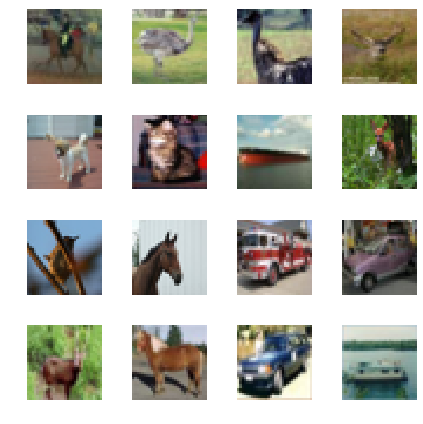

In [12]:
import itertools
generator_output = np.array(list(itertools.islice(data_generator(64), 16)))
test_images = 255. * (generator_output[:,1] / 2. + 0.5)
plot_images(test_images[:16])


For training GANs we need to further define our generator and discriminator network.
We start by defining our generator network, which should map from our noise + label space into the space of out images 
`(LATENT_DIM + LABEL --> IMAGE_DIM)`.
Adding the label the input of to both the generator and discriminator, should enforce the generator to produce samples from the according class.

In [13]:
LATENT_DIM = 64  # dimension of the latent space

def generator_fn(inputs, latent_dim=LATENT_DIM):
    x, labels = inputs
    x = tf.concat([x, labels], axis=-1)
    x = layers.Dense(4 * 4 * 256, activation='relu', input_shape=(latent_dim + 1,))(x)  #
    x = tf.reshape(x, shape=[BATCH_SIZE, 4, 4, 256])
    x = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(3, (3, 3), padding='same', activation='tanh')(x)
    return x

After defining our generator network we need to implement our discriminator.
The task of the discriminator is to measure the similarity between the fake images (output of the generator) and the real images.
So, the network maps from the image space into a 1D space where we can measure the 'distance' between the distributions 
of the real and generated images `(IMAGE_DIM + LABEL --> 1)`.
Also here we add the class label to the discriminator. To insert the information of the class label already in the block of convolutions, we just build a feature map holding the label at each pixel, and stack it on the resulting feature maps of the first convolution.

In [14]:
def discriminator_fn(x, gen_in):
    """ Discriminator network """
    noise, labels = gen_in
    x = layers.Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3))(x)
    x = tf.nn.leaky_relu(x, 0.2)
    labels = tf.tile(tf.reshape(labels, [BATCH_SIZE, 1, 1, 1]), [1, 32, 32, 1])
    x = tf.concat([x, labels], axis=-1)
    x = tf.contrib.layers.layer_norm(x)
    x = layers.Conv2D(64, (4, 4), padding='same', strides=(2, 2))(x)
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.Conv2D(128, (4, 4), padding='same', strides=(2, 2))(x)
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.Conv2D(256, (4, 4), padding='same', strides=(2, 2))(x)
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.Conv2D(512, (3, 3), padding='same')(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    return x


Note that in WGANs we can not make use of batch normalization in the critic, because the gradient penalty is calculated between sample pairs.
Therefore, [layer normalization](https://arxiv.org/abs/1607.06450) is a great alternative for normalization in the critic.

So let us use the [gradient penalty](https://arxiv.org/abs/1704.00028):
By penalizing the gradient to be 1, we enforce the lipschitz constraint needed to construct Wasserstein using the
[Kantorovich-Rubinstein duality](https://cedricvillani.org/wp-content/uploads/2012/08/preprint-1.pdf).

GP is the hyperparameter to weight the strength of the Lipschitz constrain. (higher GP --> stronger enforcing)
Here, we can make use of the preliminary implemented `wasserstein_loss` which evaluates $\mathcal{L}_{WGAN}$, **without** enforcing a Lipschitz constrain.
For this reason, we have to add the gradient penalty to the loss.


In [15]:
def discriminator_loss(model, add_summaries=True):

    loss = tf.contrib.gan.losses.wasserstein_discriminator_loss(model, add_summaries=add_summaries)
    gp_loss = GP * tf.contrib.gan.losses.wasserstein_gradient_penalty(model, epsilon=1e-10, one_sided=True, add_summaries=add_summaries)
    loss += gp_loss

    if add_summaries:
        tf.summary.scalar('discriminator_loss', loss)  # add loss to TensorBoard summary

    return loss

After defining our objective, we can choose our training parameters

In [16]:
BATCH_SIZE = 32   # number of samples fed into the framework in each iteration
GEN_LR = 0.0002   # learning rate of the generator
DIS_LR = 0.0002   # learning rate of the discriminator
GP = 10           # factor to scale the gradient penalty (higher means larger enforcing the Lipschitz constrain)
N_CRIT = 5        # number of critic iterations per generator iterations.

Now we can very easily implement our framework as estimator using tf.gan, this will heavily simplify our training procedure.
It is important to realize that we now train the critic `N_CRIT = 5` times, before updating the generator `1` time.
This allows us to stabilize the training procedure, by precisely approximating the Wasserstein distance.

In [17]:
wgan_dir = tut.get_file("gan/models/WGAN_GP", is_dir=True)

gan_estimator = tfgan.estimator.GANEstimator(
    wgan_dir,
    generator_fn=generator_fn,
    discriminator_fn=discriminator_fn,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=discriminator_loss,
    generator_optimizer=tf.train.AdamOptimizer(GEN_LR, 0.5),
    discriminator_optimizer=tf.train.AdamOptimizer(DIS_LR, 0.5),
    get_hooks_fn=tfgan.get_sequential_train_hooks(tfgan.GANTrainSteps(1, N_CRIT)),
    config=tf.estimator.RunConfig(save_summary_steps=10, keep_checkpoint_max=1, save_checkpoints_steps=200),
    use_loss_summaries=True)

INFO:tensorflow:Using config: {'_model_dir': '/home/jonas/PycharmProjects/iml2019/data/gan/models/WGAN_GP', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 200, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f198058a668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


To train our estimator we can create a TensorflowDataset out of our data generator and design a function which outputs us
batches of our dataset.
This batches we can then use to train our estimator.

In [18]:
def batched_dataset(BATCH_SIZE, LATENT_DIM, generator_fn):
    Dataset = tf.data.Dataset.from_generator(
        lambda: generator_fn(LATENT_DIM), output_types=((tf.float32, tf.float32), (tf.float32)),
        output_shapes=((tf.TensorShape((LATENT_DIM,)), tf.TensorShape((1,))), (tf.TensorShape((32, 32, 3)))))
    return Dataset.batch(BATCH_SIZE)

Finally, let us train our framework using our gan_estimator and data_pipeline.

*We skip the training here and import a pretrained estimator*.
To train the estimator, change max_steps to large values or use `steps` instead.

In [19]:
gan_estimator.train(lambda: batched_dataset(BATCH_SIZE, LATENT_DIM, generator), max_steps=1000)

INFO:tensorflow:Skipping training since max_steps has already saved.



To test the conditioning of the labels we can just build a sorted generator, generate samples and plot the resulting images.


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/jonas/PycharmProjects/iml2019/data/gan/models/WGAN_GP/model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


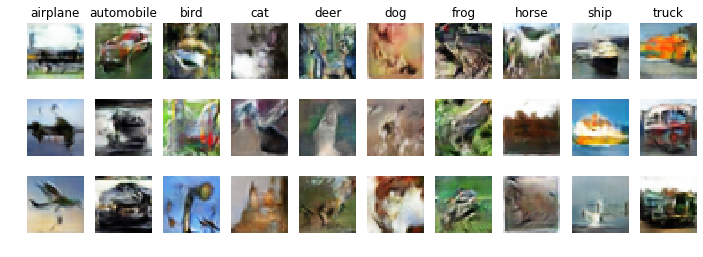

In [20]:
from plotting import plot_cond_images

def sorted_generator(LATENT_DIM):
    while True:
        nsamples = 50000
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
        labels = y_train
        nsamples = x_train.shape[0]
        images = 2 * (x_train / 255. - 0.5)
        images = images.astype(np.float32)
        noise = np.random.randn(nsamples, LATENT_DIM).reshape(nsamples, LATENT_DIM)
        labels = np.expand_dims(np.tile(np.arange(10), 5000), axis=-1)
        for i in range(nsamples):
            yield ((noise[i], labels[i]), (images[i]))

result = gan_estimator.predict(lambda: batched_dataset(BATCH_SIZE, LATENT_DIM, sorted_generator))
images = []
for i, image in zip(range(30), result):
    images.append(255 * (image / 2. + 0.5))
plot_cond_images(images)


<a name="wgan_results"></a>

### Results
We now can have a look on the improvement of generated samples during the training and inspect the losses of the WGAN. The training took around 12h on a Nvidia 1080 GTX and was trained for 100k generator iterations.

As we can see, the _gradient penalty_ is converging towards zero! This are great news, that means our critic is able to give a good estimate of the Wasserstein distance.

##### Gradient Penalty Loss 
<img src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Fgan%2Fmodels%2FWGAN_GP&files=GP_loss.svg" alt="Gradient penalty * 10" width="800"/>

If we look at the _critic loss_ we can see a convergence towards 0. (Note that due to our setup, we are maxmizing the negative Wasserstein distance, the critic gives a negative estimate of Wasserstein-1).
These are really great news, because now we can very easily monitor the GAN training.
In this case, we can see an convergence of the Wasserstein metric and expect good results.

##### Critic Loss
<img src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Fgan%2Fmodels%2FWGAN_GP&files=critic_loss.svg" alt="critic loss" width="800"/>

So let's have a look on the samples during the training:


![WGAN_GP samples](https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Fgan%2Fmodels%2FWGAN_GP&files=cond_WGAN.gif)

These samples look much better, than the ones obtained using the vanilla approach<sup>[6](#myfootnote6)</sup>.
Even for this relatively simple generator and discriminator model, we can clearly identify in the generated samples features belonging to the according class labels.
Congratulations, we succesfully trained our first Wasserstein GAN!

&nbsp;
&nbsp;

_Footnotes_

<a name="myfootnote4">7</a>: One could complain that the conditioning on the labels improved the performance and prevent mode collapsing. But indeed, the WGAN-GP setting also performs well when trained completely unsupervised, which is not true for the vanilla GAN setting.

&nbsp;
&nbsp; 
<a name="sngan"></a>
# Spectral Normalization for Generative Adversarial Networks - SN-GANs
&nbsp; 

<details><summary> <button type="button">Display detailed text</button> </summary>
<p>

<a name="sngan_normalization"></a>
### Gradient Penalty in Terms of Normalization 
To understand why SN-GANs are working, one have to interpret the gradient penalty in a little bit different way.
The *gradient penalty* was introduced to estimate the Wasserstein distance between the distribution
of real and fake samples using the _critic_ network. That was desirable when interpreting GAN training in terms of divergence minimization,
because the Wasserstein distance is a much more suitable distance measure for disjoint distributions than the JS-divergence.
Another way to review the gradient penalty is in a way somehow to normalization/ regularization.
Remember, that for training vanilla GANs, using regularization and normalization (noise, regularizer, batch normalization) was crucial
for obtaining reasonable results. But the sort of normalization we focus on in this chapter, is way different.

<a name="ns_gan"></a>
To overcome the issue of *vanishing gradients* already in [Goodfellow et al.](https://arxiv.org/abs/1406.2661) an alternative
loss was proposed, which is known as _label switching_ (because for implementation you just have to switch the labels of true and fakes).

$ \mathcal{L}_{NS, Gen} =  -\mathbb{E}_{\mathbf{z} \sim p_z(\mathbf{z})} [log(D(G_{\theta}(\mathbf{z})))]$

The gradients of the discriminator do not vanish anymore, but can provide very instable updates. [Arjovsky and Bottou](https://arxiv.org/abs/1701.04862)
showed, that the provided gradients for a noisy discriminator follows a Cauchy distribution (infinite expectation and variance).
In a more figurative sense, samples which lie outside of the support of the real and fake images will be very noisy and can blow
up massively which disturbs the training.
Therefore, penalizing large gradients in the discriminator is from major importance.


These considerations explain the observation, that GANs using the "non saturating loss" and the gradient penalty instead of _Wasserstein_ + GP
are an alternative and stable GAN setup. Here, the gradient penalty just penalize large gradients by requiring gradients of norm 1 from the discriminator what also will prevent mode dropping.

<a name="sngan_theory"></a>
### Spectral Normalization

The observation that stabilizing the gradient is a suitable way to train NSGANs (non saturating GANs), leads
to idea to implement the Lipschitz constrain in a much more direct way. (Remember, we have to update the critic several times
to get good feedback for ther generator).
[Miyato, Kataoka, Koyama, Yoshida](https://arxiv.org/abs/1802.05957) proposed to do this, by normalizing the discriminator 
weights using the spectral norm.
This will have the big advantage that the discriminator do not need to be updated several times, which increase the speed 
of thw GAN training.

#### Spectral norm


Let us remember the definition of the spectral norm:

$\sigma(\mathbf{W}) = ||\mathbf{W}||_{2} = \max_{x\neq 0} \frac{||\mathbf{W}x||_2}{||x||_2} = \max_{||x||_2=1} ||\mathbf{W}x||_2$.

Figuratively speaking, the spectral norm of $W$ is the maximum stretch factor of a unit vector $x$ after multiplication with matrix $W$.

<img src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Fgan%2Fimages&files=streched_vector.png" alt="drawing by Quartl - wikipedia" width="300"/>
<div style="text-align: right"> image credit: Quartl, wikipedia </div>

This allows us to draw a connection between the Lipschitz norm and spectral normalization.

So we can express the Lipschitz norm using the spectral norm:

$||D(x)||_{\mathrm{Lip}} = \sup_{x} \sigma(\nabla_x D(x))=  \sup_{x} \sigma(\nabla_x Wx) = \sigma(W)$
 
We cann see directly, that for enforcing a similar Lipschitz constrain as used in WGAN-GP $||D(x)||_{\mathrm{Lip}} \leq 1$
we just need to normalize the weights $W$ using: 

$\mathbf{W}_{SN}=\frac{\mathbf{W}}{\sigma(\mathbf{W})}$.


Because calculating the spectral norm can be quiet time consuming, the proposed approach is to use a fast approximation of the spectral norm
using the _power iteration method_.

Note that this type of normalization is different then typical regularization like L1 or L2, because using spectral
normalization we are **not** adding an additional penalty term to the objective.

In a figurative sense, just think of the normalization of the SN-GAN, as referee to control the gradient.
Our discriminator now get as as input a vector $f$ of features. In the first layer the weight matrix $W$ is multiplied with this vector $f$.
(normal transformation in fully connected layers). So the feature vector is rotated and stretched.
Now, we constrain the weight matrix $W$ with the spectral norm. Hence, no transformations with a stretching factor larger than 1
is allowed (just see the image of the spectral norm for an easy understanding). These normalization helps to prevent that
the layer focus on a specific feature (direction) only which would induce large gradients.
This helps to control the gradients of the discriminator outside the distribution of real and fake samples and prevents mode collapsing.


### Comment on Mode Dropping
One now could argue that spectral normalization will not be able to prevent GANs from mode collapsing, because we are not minizing a soft metric like the Wasserstein distance.

To understand why SNGANs do not suffer from mode collapsing, one could interpret mode collapsing as overtraining of the dscriminator. The discriminator can very easily find features which are different between real and fake images (we are dealing with very high dimensional data). Very likely, the discriminator will focus on one or a few features very particular.
Therefore, the gradients of the discriminator will all point towards a very restricted space of the phase space and become very large.
This will heavily push the generator, which will collapse at the restricted space of the phase space. Subsequently, the discriminator will focus onto another part of the phase space, the generator do not cover. This will shift the generator to the next mode. This leads to the cycling behavior we observed by training the vanilla GAN in the beginning on CIFAR10.

By normalizing the gradients, we are somehow regularizing the feedback of our disriminator. Hence, the generator can not be pushed towards a single mode at once. This make mode collapsing very unlikely.

</p>
</details>




<a name="sngan_code"></a>
## Spectral Normalization GANs for Cosmic Ray induced Air Showers

After dealing with the CIFAR dataset let us now tackle our first **physics dataset** with GANs:
a dataset of cosmic ray induced air showers.
When ultra-high energy cosmic rays (UHECRs) penetrate the atmosphere of the earth, they interact with the air molecules and 
particle cascades are created. For air showers induced by UHECRs (energies > 10 EeV) the footprint on the Earth's surface
is in the order of several 10 km².
The dataset contains footprints of air showers measured by observatories like the [Pierre Auger Observatory](https://www.auger.org/)
and induced by cosmic rays between 1 - 100 EeV and was used to train the first Wasserstein GAN on physics data [Comput Softw Big Sci (2018) 2: 4.](https://link.springer.com/article/10.1007%2Fs41781-018-0008-x).
The dataset was generated using a parametrized simulation, and described in [Astropart. Phys. 97 (2017) 46](https://www.sciencedirect.com/science/article/pii/S0927650517302219?via%3Dihub),
additionally [you can download the code](https://git.rwth-aachen.de/DavidWalz/airshower).

Note that several things changed, after switching the dataset from photographs to physics:

|Type| Signal Patterns (Calorimeter images)        |  Pictures           |
| :------------- :| :------------- :|:-------------:|
| Channels | many, up to tenth of layers   | 3 (RGB) |
| Resolution | relatively low (20 x 20) | high resolution (higher than 1000 x 1000)    |
| Pixel range | several magnitudes, **logarithmic**  | 0-255, **linear**|
| Distribution pixels | sparse, high local correlations | coherent, high local and global correlations |

Especially the logarithmic distribution of signals and the sparsity offer a new challenge.

The SN-GAN is a nice alternative to the Wasserstein GAN, by "encoding" the Lipschitz constrain directly in the weights of
the discriminator.
For this reason, let us implement our first SN-GAN.

## Implementation of SN-GAN

No we are going to implement a Generative Adversarial Network using spectral normalization in the disciriminator.

First of all we need the basic imports:

In [21]:
import tensorflow as tf
import numpy as np
import tutorial as tut

layers = tf.layers
tfgan = tf.contrib.gan



In [22]:
LATENT_DIM = 512
path_cr = tut.get_file("gan/data/airshower_footprints.npz")

def cr_batched_dataset(BATCH_SIZE, LATENT_DIM, generator_fn):
    Dataset = tf.data.Dataset.from_generator(
        lambda: generator_fn(LATENT_DIM), output_types=(tf.float32, tf.float32),
        output_shapes=(tf.TensorShape((LATENT_DIM,)), tf.TensorShape((9, 9, 1))))
    return Dataset.batch(BATCH_SIZE)


def cr_data_generator(LATENT_DIM):
    while True:
        file = np.load(path_cr)
        footprints = file['shower_maps']
        nsamples = footprints.shape[0]
        noise = np.random.randn(nsamples, LATENT_DIM).reshape(nsamples, LATENT_DIM)
        idx = np.random.permutation(nsamples)
        noise = noise[idx]
        footprints = footprints[idx]
        for i in range(nsamples):
            yield (noise[i], footprints[i])


Let us check the pipeline and plot a few air shower footprints from the "real dataset".
The footprints were already preprocessed using $S' = log10(S+1)\;$ and by shifting the hottest station into the center of 
the footprint.

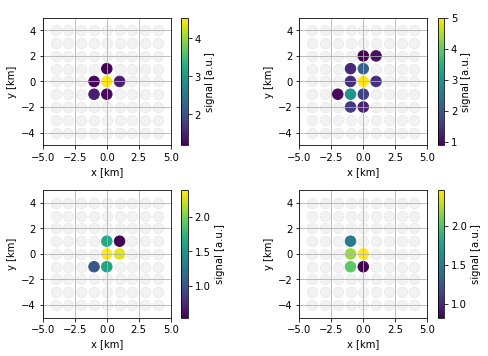

In [23]:
from plotting import plot_multiple_footprints
import itertools

test_footprints = np.array(list(itertools.islice(cr_data_generator(0), 16)))[:, 1]
plot_multiple_footprints(test_footprints)



To generate air shower footprints we now can start to implement our generator and discriminator.


In [24]:
LATENT_DIM=80

def generator_fn_cr(x, latent_dim=LATENT_DIM):
    x = layers.Dense(1 * 1 * 256, activation='relu', input_shape=(latent_dim,))(x)  #
    x = tf.reshape(x, shape=[BATCH_SIZE, 1, 1, 256])
    x = layers.Conv2DTranspose(256, (3, 3), strides=(3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=(3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(1, (3, 3), padding='same', kernel_initializer=tf.initializers.random_uniform(minval=0, maxval=2.), activation='relu')(x)
    return x
 

This generator just follows the typical DCGAN structure using transposed convolutions and maps from `(laten_dim,)` to footprints
with shape `(9,9,1)`.

Note that in the last layer we need to have a 'ReLU' activation, as the footprints are very sparse.
In the early stage of the training, this can lead to dying ReLUs and sparse gradients, hence we can initialize the
bias vector to 0 (default) and the weights between [0, 2] to overcome this issue.

Thereafter, we can build our discriminator. Here, we need to implement spectral normalization in our layers.

### Implementation of the Spectral norm
The implementation of the spectral norm is relatively straight forward, we just have to control the weights in the respective layer.
Hence, we have to wrap the normalization around the normal layer.

Let us try to build a fully connected layer using spectral normalization.

In [25]:
from ganlayers import spectral_norm  # function returns W / SN(W), normalized weight matrix using the power iteration method

def dense_sn(inputs, units, name,
             activation_fn=None,
             use_bias=True,
             kernel_initializer=tf.glorot_uniform_initializer(),
             bias_initializer=tf.zeros_initializer(),
             use_gamma=False,
             factor=None):

    input_shape = inputs.get_shape().as_list()

    with tf.variable_scope(name):
        kernel = tf.get_variable('kernel', shape=(input_shape[-1], units), initializer=kernel_initializer)  # create new weight matrix
        outputs = tf.matmul(inputs, spectral_norm(kernel, use_gamma=use_gamma, factor=factor))  # apply linear transformation
        if use_bias is True:
            bias = tf.get_variable('bias', shape=(units,), initializer=bias_initializer)
            outputs = tf.nn.bias_add(outputs, bias)  # add bias
        if activation_fn is not None:
            outputs = activation_fn(outputs)  # apply non-linear activation to the output 

    return outputs



We can now use the layer to build the discriminator. (The layer `conv2d_sn` is implemented in a similar way as `dense_sn`.)


In [26]:
from ganlayers import conv2d_sn

def discriminator_fn_cr(x):
    x = conv2d_sn(x, 64, (3, 3), name='sn_conv00', padding='same')
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.BatchNormalization()(x)
    x = conv2d_sn(x, 64, (4, 4), name='sn_conv01', padding='same', strides=(2, 2))
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.BatchNormalization()(x)
    x = conv2d_sn(x, 128, (3, 3), name='sn_conv10', padding='same')
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.BatchNormalization()(x)
    x = conv2d_sn(x, 128, (4, 4), name='sn_conv11', padding='same', strides=(2, 2))
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.BatchNormalization()(x)
    x = conv2d_sn(x, 256, (3, 3), name='sn_conv20', padding='same')
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.Flatten()(x)
    x = dense_sn(x, 1, name='output')
    return x


In [27]:
BATCH_SIZE = 128
GEN_LR = 0.0001
DIS_LR = 0.0001
GP = 10
N_CRIT = 1

After the last layer we do not need to apply an activation, hence this can be controlled using the loss provided by `tf.gan`.

Subsequently, we can build our estimator.
Remember that we need the [**non saturating** loss](#ns_gan) `tfgan.losses.modified_generator_loss`, to prevent vanishing gradients.


In [28]:
sn_dir = tut.get_file("gan/models/SN_GAN", is_dir=True)

gan_estimator = tfgan.estimator.GANEstimator(
    sn_dir,
    generator_fn=generator_fn_cr,
    discriminator_fn=discriminator_fn_cr,
    generator_loss_fn=tfgan.losses.modified_generator_loss,
    discriminator_loss_fn=tfgan.losses.modified_discriminator_loss,
    generator_optimizer=tf.train.AdamOptimizer(GEN_LR, 0.5),
    discriminator_optimizer=tf.train.AdamOptimizer(DIS_LR, 0.5),
    get_hooks_fn=tfgan.get_sequential_train_hooks(tfgan.GANTrainSteps(1, N_CRIT)),
    config=tf.estimator.RunConfig(save_summary_steps=100, keep_checkpoint_max=3, save_checkpoints_steps=10000),
    use_loss_summaries=True)


INFO:tensorflow:Using config: {'_model_dir': '/home/jonas/PycharmProjects/iml2019/data/gan/models/SN_GAN', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f19da823c18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Afterwards, we could train our estimator.

### Results
Instead of training, we again load a pretrained model which was trained around 5h on a Nvidia 1080 GTX and plot some 
air shower footprints generated by our model.

INFO:tensorflow:Skipping training since max_steps has already saved.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/jonas/PycharmProjects/iml2019/data/gan/models/SN_GAN/model.ckpt-305000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


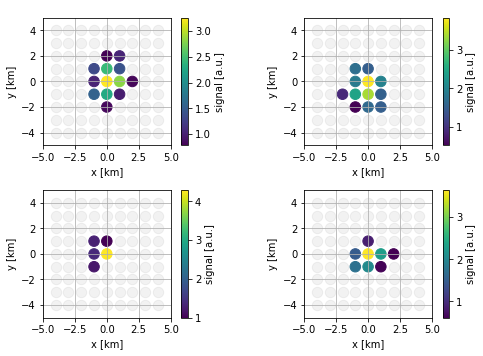

In [29]:
gan_estimator.train(lambda: cr_batched_dataset(BATCH_SIZE, LATENT_DIM, cr_data_generator), max_steps=1000)
iter = gan_estimator.predict(lambda: cr_batched_dataset(BATCH_SIZE, LATENT_DIM, cr_data_generator))
generated = []

for i, gen_foot in zip(range(1000), iter):
    generated.append(gen_foot)

generated = np.array(generated)    
plot_multiple_footprints(generated)


We can see concentrated showers in the center of the array cutout, and a decrease of signals for stations with
higher distances to the shower core. This is exactly what we would expect from physics.

Let us now do short but more quantitative analysis of our generated showers and compare the distributions of total signals.

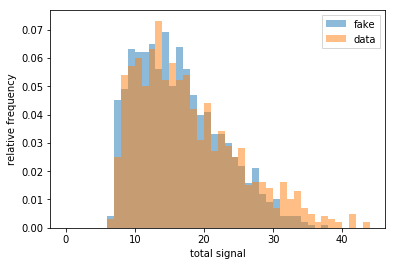

In [30]:
from plotting import plot_total_signal
import tutorial as tut

path_cr = tut.get_file("gan/data/airshower_footprints.npz")
file = np.load(path_cr)
data = file['shower_maps'][0:1000]

plot_total_signal(fake=np.sum(generated, axis=(3, 2, 1)), data=np.sum(
    data, axis=(3, 2, 1)))


Furthermore, we can investigate the sparsity of the images and compare if the distributions of stations with measured signals 
is similar.

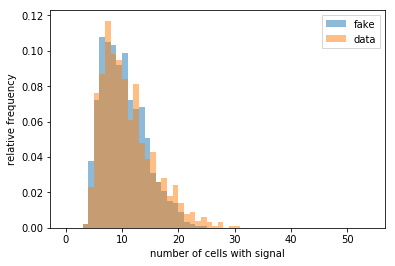

In [31]:
from plotting import plot_cell_number_histo

plot_cell_number_histo(fake=np.sum(generated > 0, axis=(
    3, 2, 1)), data=np.sum(data > 0, axis=(3, 2, 1)))


###### Discriminator Loss 
When studying the loss of the discriminator we can not see any kind of convergence.
We have still the same issue of not estimating a distance (something like "relative differences") in the discriminator but classifying only.
<img src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Fgan%2Fmodels%2FSN_GAN&files=loss.svg" alt="drawing" width="800"/>

###### Generated samples during training
<img src="https://cernbox.cern.ch/index.php/s/xDYiSmbleT3rip4/download?path=%2Fgan%2Fmodels%2FSN_GAN&files=airshower_SN_GAN.gif" width="600"/>


&nbsp; &nbsp; &nbsp; 
# Generating Calorimeter Images

Let us now put all together and build a combination of spectral normalization and Wasserstein
The _gradient penalty_ put a similar constrain on the critic/discriminator, but in a different way then spectral normalization.

##### Differences between Spectral Normalization and Gradient Penalty
| Wasserstein | Spectral Normalization |
| :-------------: | :-------------: |
| constrain gradient directly | uses weight normalization |
| non stationary training routine "local normalization" | relatively stable training "global normalization" |
| $\checkmark$ nearly no constrain of feature learning | $\times$ can reduce complexity of feature space |
| $\times$ needs $\geq 5$ discriminator iterations | $\checkmark$ only $1$ discriminator iteration needed |
| $\times$ needs tuning of learning rates an "ncr" iterations | $\checkmark$ stable training for a wide range of parameters |
| $\checkmark$ provides meaningful metric | $\times$ do not provides meaningful metric |

 So let us take the best of both worlds and combine both techniques. 

### Spectral Normalization in the generator

Recently, it was found that the singular values of the generator are related to the GAN performance.
[Odena et al.](https://arxiv.org/abs/1802.08768) proposed to use __Jacobian clamping__ to stabilize the training process.
Since, spectral normalization is performing similar we will use spectral normalization instead.

### Implementation
Let us use for this last GAN implementation a much more complicated dataset as very similar used in [Erdmann, Glombitza, Quast](https://link.springer.com/article/10.1007%2Fs41781-018-0019-7).
For simplicity reasons we are only using 3 layers and a single energy of 100 GeV electrons.
Hence, using label conditioning is useless in this setup. 

So let us begin to implement the data pipeline and plot some calorimeter images.

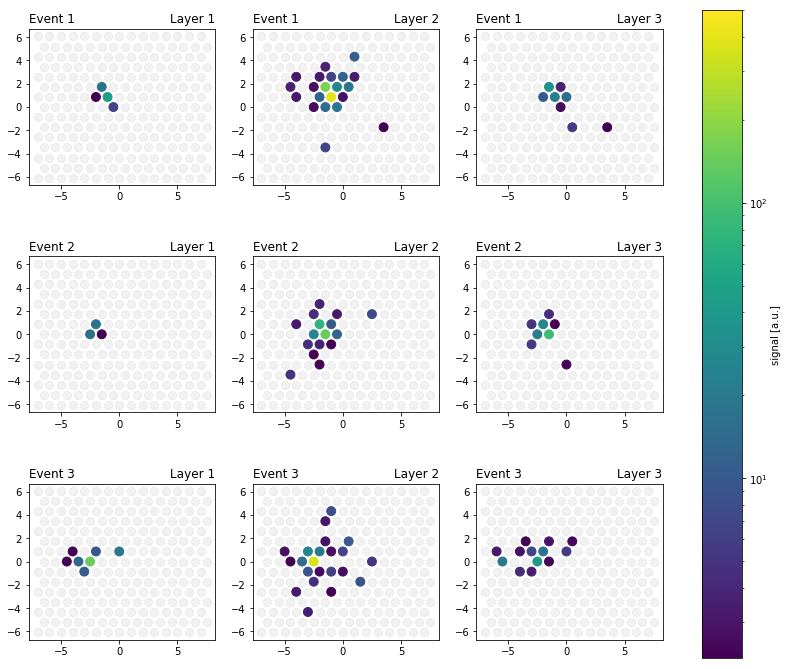

In [32]:
import tensorflow as tf
import numpy as np
from plotting import plot_calo_images
import tutorial as tut

path_calo = tut.get_file("gan/data/3_layer_calorimeter_padded.npz")
LATENT_DIM = 64

def calo_batched_dataset(BATCH_SIZE, LATENT_DIM, generator_fn):
    Dataset = tf.data.Dataset.from_generator(
        lambda: generator_fn(LATENT_DIM), output_types=(tf.float32, tf.float32),
        output_shapes=(tf.TensorShape((LATENT_DIM,)), tf.TensorShape((15, 15, 3))))
    return Dataset.batch(BATCH_SIZE)


def calo_data_generator(LATENT_DIM):
    while True:
        calo_ims = np.load(path_calo)['data']
        nsamples = calo_ims.shape[0]
        calo_ims = np.log10(calo_ims+1)
        calo_ims = calo_ims.astype(np.float32)
        noise = np.random.randn(nsamples, LATENT_DIM).reshape(nsamples, LATENT_DIM)
        idx = np.random.permutation(nsamples)
        noise = noise[idx]
        calo_ims = calo_ims[idx]
        for i in range(nsamples):
            yield (noise[i], calo_ims[i])


import itertools
images = np.array(list(itertools.islice(calo_data_generator(1), 3)))[:, 1]
images = 10**images - 1
plot_calo_images(images)


We can observed sparse showers evolving in the electromagnetic sampling calorimeter.
Furthermore, we can see that our calorimeter features a hexagonal grid. Therefore, we use offset coordinates as described
in [Astropart. Phys. 97 (2017) 46](https://www.sciencedirect.com/science/article/pii/S0927650517302219).

In [33]:
layers = tf.layers
tfgan = tf.contrib.gan
from ganlayers import conv2d_transpose_sn, conv2d_sn, dense_sn

def generator_fn(x):
    x = layers.Dense(3 * 3 * 256, activation='relu')(x)  #
    x = tf.reshape(x, shape=[BATCH_SIZE, 3, 3, 256])
    x = conv2d_transpose_sn(x, 256, (4, 4), strides=(2, 2), padding='same', name='sn_conv_gen_transposed01', activation=tf.nn.relu)
    x = layers.BatchNormalization()(x)
    x = conv2d_transpose_sn(x, 128, (3, 3), strides=(2, 2), padding='valid', name='sn_conv_gen_transposed02', activation=tf.nn.relu)
    x = layers.BatchNormalization()(x)
    x = conv2d_transpose_sn(x, 64, (3, 3), padding='valid', name='sn_conv_gen_transposed03', activation=tf.nn.relu)
    x = layers.BatchNormalization()(x)
    x = conv2d_sn(x, 64, (3, 3), name="sn_gen_conv01", padding='same', activation=tf.nn.relu)
    x = layers.BatchNormalization()(x)
    x = conv2d_sn(x, 3, (3, 3), name="sn_gen_conv02", padding='same', kernel_initializer=tf.initializers.random_uniform(minval=0.1, maxval=100.), activation=tf.nn.relu)
    return x


In the generator we make use of spectral normalization and batch normalization.
Note, that we again uses the initialization trick in the last layer of the generator to overcome dying ReLUs and sparse gradients which can lead to a collapse of the training..

In [34]:
def discriminator_fn(x):
    """ Discriminator network """
    x = conv2d_sn(x, 64, (3, 3), name="sn_conv01", padding='same')
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = conv2d_sn(x, 64, (5, 5), name="sn_conv02", padding='same', strides=(2, 2))
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = conv2d_sn(x, 128, (3, 3), name="sn_conv03", padding='same')
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = conv2d_sn(x, 128, (4, 4), name="sn_conv04", padding='same', strides=(2, 2))
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = conv2d_sn(x, 256, (3, 3), name="sn_conv05", padding='same')
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = conv2d_sn(x, 512, (3, 3), name="sn_conv06", padding='same')
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.Flatten()(x)
    x = dense_sn(x, 1, name='sn_dense01')
    return x


After we successfully implemented our generator and critic network, we need to implement the Wasserstein loss with gradient penalty


In [35]:
def discriminator_loss(model, add_summaries=True):

    loss = tf.contrib.gan.losses.wasserstein_discriminator_loss(model, add_summaries=add_summaries)
    gp_loss = GP * tf.contrib.gan.losses.wasserstein_gradient_penalty(model, epsilon=1e-10, one_sided=True, add_summaries=add_summaries)
    loss += gp_loss

    if add_summaries:
        tf.summary.scalar('discriminator_loss', loss)

    return loss
 

To start generating calorimeter samples let us build our framework using the GANEstimator and set the training parameters.

In [36]:
BATCH_SIZE = 64
GEN_LR = 0.0001
DIS_LR = 0.0001
GP = 10
N_CRIT = 5
wgan_sn_dir = tut.get_file("gan/models/WGAN_SN", is_dir=True)

gan_estimator = tfgan.estimator.GANEstimator(
    wgan_sn_dir,
    generator_fn=generator_fn,
    discriminator_fn=discriminator_fn,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=discriminator_loss,
    generator_optimizer=tf.train.AdamOptimizer(GEN_LR, 0.5, 0.9),
    discriminator_optimizer=tf.train.AdamOptimizer(DIS_LR, 0.5, 0.9),
    get_hooks_fn=tfgan.get_sequential_train_hooks(tfgan.GANTrainSteps(1, N_CRIT)),
    config=tf.estimator.RunConfig(save_summary_steps=100, keep_checkpoint_max=3, save_checkpoints_steps=10000),
    use_loss_summaries=True)


INFO:tensorflow:Using config: {'_model_dir': '/home/jonas/PycharmProjects/iml2019/data/gan/models/WGAN_SN', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f19dab299e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Again we load a pretrained model and inspect first samples generated by our model.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/jonas/PycharmProjects/iml2019/data/gan/models/WGAN_SN/model.ckpt-200000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
iteration 0
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800
iteration 900


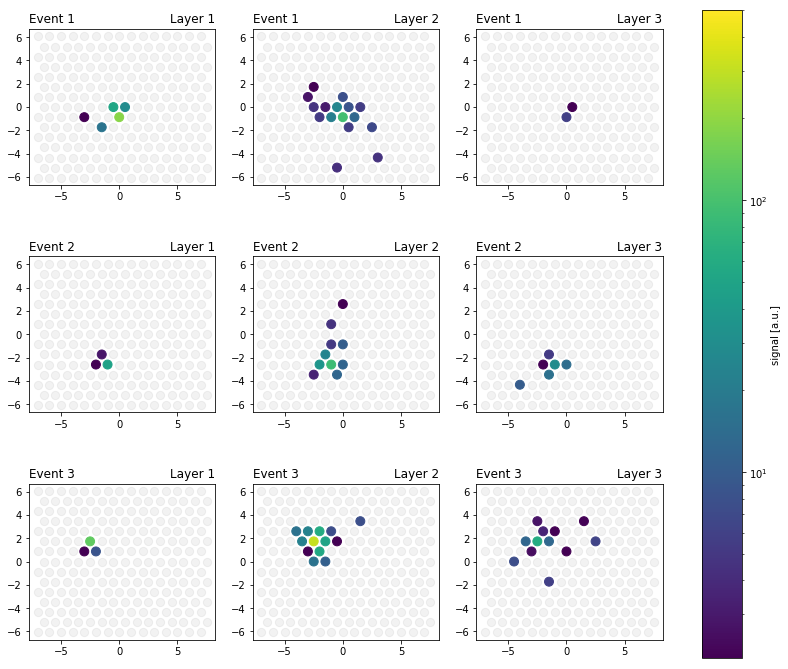

In [37]:
from plotting import plot_average_image, plot_calo_images

calo_iter = gan_estimator.predict(lambda: calo_batched_dataset(BATCH_SIZE, LATENT_DIM, calo_data_generator))
generated_calo = []
for i, image in zip(range(1000), calo_iter):
    generated_calo.append(10**image - 1)
    if i%100 == 0:
        print("iteration", i)
generated_calo = np.array(generated_calo)
plot_calo_images(generated_calo)


We can further investigate the correlations between the layer.
It is from major importance that our generative model is able to capture this correlations!

Note that genrating new samples using jupyter notebooks on a CPU can be quiet time consuming.  

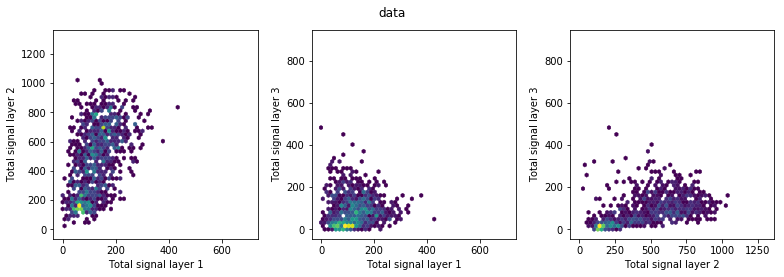

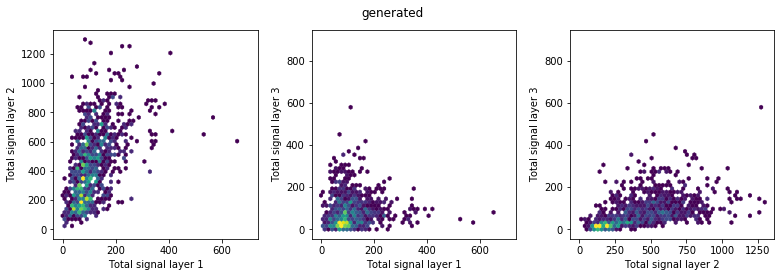

In [38]:
from plotting import plot_layer_correlations

path_calo = tut.get_file("gan/data/3_layer_calorimeter_padded.npz")
calo_ims = np.load(path_calo)['data'][:1000]
plot_layer_correlations(np.sum(calo_ims, axis=(1, 2)), datatype='data')
plot_layer_correlations(np.sum(generated_calo, axis=(1, 2)), datatype='generated')


This correlation looks good for a first try 'out of the box'.

Finally, we will have a look on the occupancy of the generated and real samples.


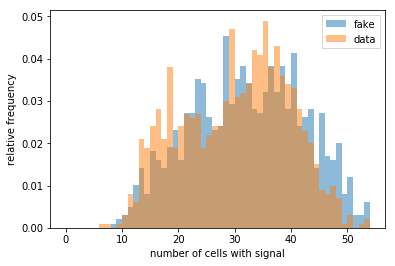

In [39]:
import numpy as np
from plotting import plot_cell_number_histo
plot_cell_number_histo(fake=np.sum(generated_calo > 0, axis=(1, 2, 3)), data=np.sum(calo_ims > 0, axis=(1, 2, 3)))


The distribution of triggered cells look reasonable, not bad for a first shot!
It is a well known in the HEP community (see [here](https://link.springer.com/article/10.1007%2Fs41781-018-0019-7) or [here](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.97.014021)),
that the sparsity in calorimeters is a big challenge and needs further investigations.

There is much more one could try:
- Decay tune optimizer / deacy of learning rates
- Use different preprocessing
- Use very deep models
- Design model which captures symmetry of the problem
- [Progressive growing of GANs](https://arxiv.org/abs/1710.10196)
- Make use of [attention](https://arxiv.org/abs/1805.08318) (especially for high resolution cases)